In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

In [22]:
dirnormal = r'C:\Users\lapt1\Downloads\Potholes Detection\normal'
dirpothole = r'C:\Users\lapt1\Downloads\Potholes Detection\potholes'

In [23]:
# Create dataframe for custom loading
def get_df_from_dir(base_dir, label):
    files = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    return pd.DataFrame({'filename': files, 'label': str(label)})

df_normal = get_df_from_dir(dirnormal, 0)
df_pothole = get_df_from_dir(dirpothole, 1)
df_all = pd.concat([df_normal, df_pothole], ignore_index=True)
df_all = df_all.sample(frac=1).reset_index(drop=True)  # shuffle

In [24]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df_all['label']), y=df_all['label'])
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [25]:
# Batch size test set
batch_sizes = [16, 32, 64]
history_dict = {}
fine_tune_history_dict = {}

for batch_size in batch_sizes:
    print(f"\n--- Training with batch size: {batch_size} ---\n")

    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_gen = datagen.flow_from_dataframe(
        dataframe=df_all,
        x_col='filename',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',
        subset='training',
        shuffle=True,
        seed=42
    )

    val_gen = datagen.flow_from_dataframe(
        dataframe=df_all,
        x_col='filename',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',
        subset='validation',
        shuffle=False
    )

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=1, class_weight=class_weights_dict)

    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    fine_tune_history = model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=1, callbacks=[reduce_lr], class_weight=class_weights_dict)

    history_dict[batch_size] = history
    fine_tune_history_dict[batch_size] = fine_tune_history


--- Training with batch size: 16 ---

Found 545 validated image filenames belonging to 2 classes.
Found 136 validated image filenames belonging to 2 classes.


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 709ms/step - accuracy: 0.8057 - loss: 0.4637 - val_accuracy: 0.9559 - val_loss: 0.1424
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 610ms/step - accuracy: 0.9454 - loss: 0.1241 - val_accuracy: 0.9632 - val_loss: 0.1378
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 594ms/step - accuracy: 0.9476 - loss: 0.1389 - val_accuracy: 0.9632 - val_loss: 0.0973
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 449ms/step - accuracy: 0.9796 - loss: 0.0758 - val_accuracy: 0.9485 - val_loss: 0.1375
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 466ms/step - accuracy: 0.9660 - loss: 0.0840 - val_accuracy: 0.9485 - val_loss: 0.1058
Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 574ms/step - accuracy: 0.8322 - loss: 0.3769 - val_accuracy: 0.9632 - val_loss: 0.1467 - learning_rate: 1.0000e-05
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 522ms/step - accuracy: 0.9301 - loss: 0.1990 - val_accuracy: 0.9338 - val_loss: 0.1306 - learning_rate: 1.0000e-05
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 522ms/s

c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7061 - loss: 0.6610 - val_accuracy: 0.9191 - val_loss: 0.2172
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 966ms/step - accuracy: 0.9199 - loss: 0.1956 - val_accuracy: 0.9191 - val_loss: 0.1569
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 993ms/step - accuracy: 0.9572 - loss: 0.1406 - val_accuracy: 0.9559 - val_loss: 0.1375
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 941ms/step - accuracy: 0.9664 - loss: 0.0819 - val_accuracy: 0.9338 - val_loss: 0.1271
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9704 - loss: 0.0863 - val_accuracy: 0.9706 - val_loss: 0.1181
Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9227 - loss: 0.2055 - val_accuracy: 0.9559 - val_loss: 0.1221 - learning_rate: 1.0000e-05
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9299 - loss: 0.2099 - val_accuracy: 0.9706 - val_loss: 0.1144 - learning_rate: 1.0000e-05
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy:

c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.7129 - loss: 0.5546 - val_accuracy: 0.9559 - val_loss: 0.1439
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9396 - loss: 0.1638 - val_accuracy: 0.9265 - val_loss: 0.1572
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.9636 - loss: 0.1159 - val_accuracy: 0.9338 - val_loss: 0.1716
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.9517 - loss: 0.1122 - val_accuracy: 0.9559 - val_loss: 0.1645
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.9714 - loss: 0.0902 - val_accuracy: 0.9191 - val_loss: 0.1527
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.8679 - loss: 0.2850 - val_accuracy: 0.9485 - val_loss: 0.1602 - learning_rate: 1.0000e-05
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.9100 - loss: 0.2198 - val_accuracy: 0.9559 - val_loss: 0.1482 - learning_rate: 1.0000e-05
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9171 - loss: 0.2197 - 

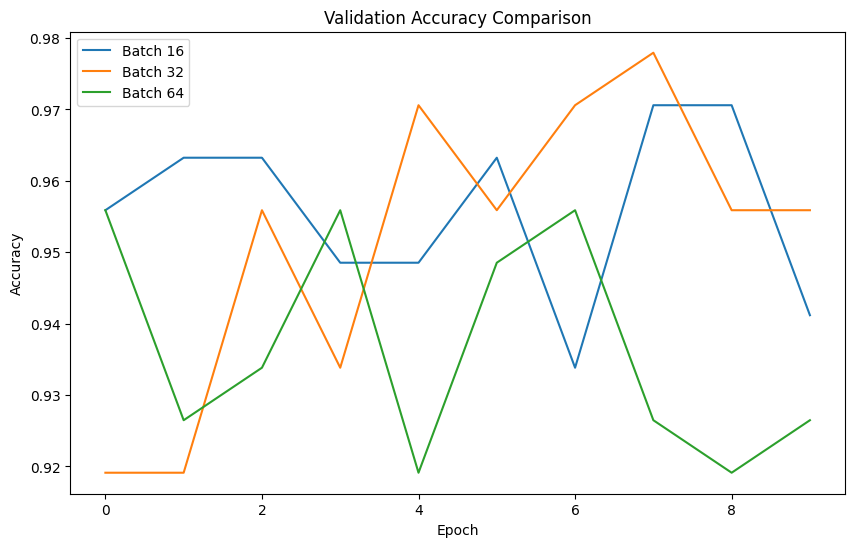

In [26]:
# Plotting accuracy comparison
plt.figure(figsize=(10, 6))
for batch_size in batch_sizes:
    acc = history_dict[batch_size].history['val_accuracy'] + fine_tune_history_dict[batch_size].history['val_accuracy']
    plt.plot(acc, label=f'Batch {batch_size}')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Batch 32 showed the most stable and high validation accuracy from epoch to epoch, with a peak around 0.978.

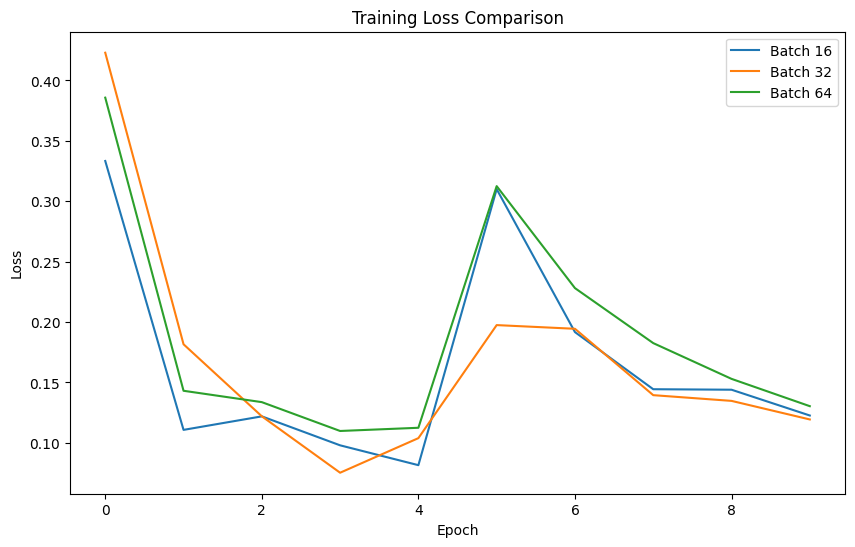

In [27]:
# Example: Plot training loss comparison
plt.figure(figsize=(10, 6))
for batch_size in batch_sizes:
    loss = history_dict[batch_size].history['loss'] + fine_tune_history_dict[batch_size].history['loss']
    plt.plot(loss, label=f'Batch {batch_size}')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Batch 32 has the lowest training loss consistently in the middle to late epochs, which means the model learns quite efficiently.

There is no noticeable indication of overfitting as the loss remains low without a large divergence from the validation accuracy.

Found 136 validated image filenames belonging to 2 classes.


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


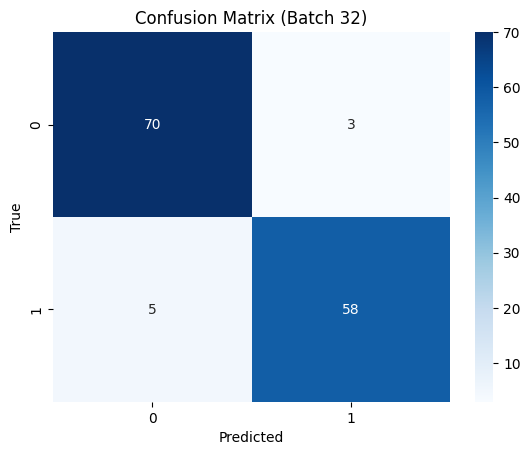

In [28]:
# Example: Display confusion matrix on validation set for one batch size (e.g., 32)
batch_to_show = 32
val_gen = datagen.flow_from_dataframe(
    dataframe=df_all,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_to_show,
    class_mode='binary',
    subset='validation',
    shuffle=False
)
preds_proba = model.predict(val_gen)
preds = (preds_proba > 0.5).astype("int32")
y_true = val_gen.classes

cm = confusion_matrix(y_true, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Batch {batch_to_show})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy = (58 + 70) / (58 + 70 + 3 + 5) = 128 / 136 ≈ 94.12%

The accuracy of the model is approximately 94.12%.
The model was able to classify both classes well, with FN and FP being quite low.

In [29]:
# Print F1 Score
print("F1 Score:", f1_score(y_true, preds))

F1 Score: 0.9354838709677419


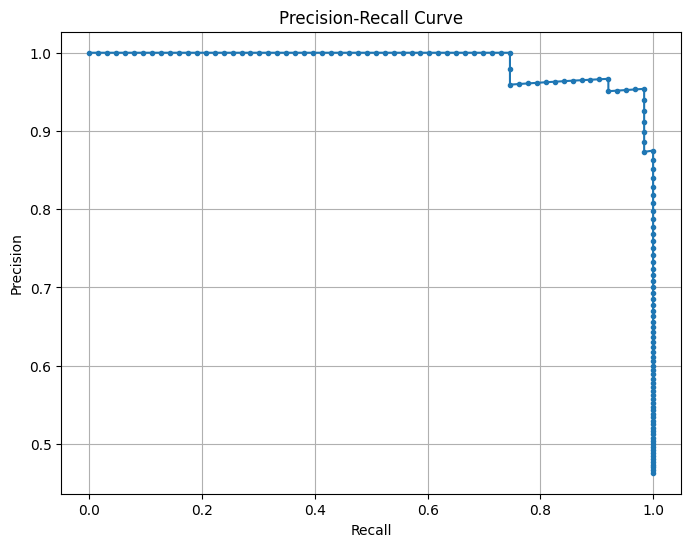

In [30]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, preds_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

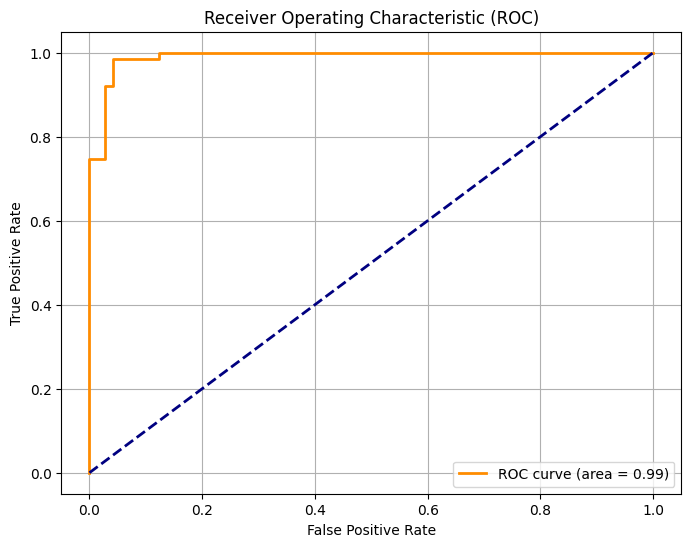

In [31]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, preds_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

This shows a very good trade-off between true positive rate and false positive rate.

In [35]:
model.save("model.keras")
print("Model telah disimpan")

Model telah disimpan
